In [41]:
# Standard Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Scikit-Learn Libraries
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, log_loss, confusion_matrix, classification_report
)

# 3D Plotting
from mpl_toolkits.mplot3d import Axes3D

**Load the data**

In [6]:
# Define the path to the raw data
raw_data_path = os.path.join(
    os.getcwd(), "..", "..", "data", "raw", "raw_data.csv"
)

df = pd.read_csv(raw_data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Print some data**

In [7]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1669,5405-ZMYXQ,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Credit card (automatic),74.60,548.9,No
2649,3027-YNWZU,Female,0,Yes,No,64,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),25.00,1584.8,No
3090,2386-LAHRK,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,Yes,No,Month-to-month,Yes,Mailed check,53.50,53.5,Yes
5263,9591-YVTEB,Male,1,No,No,55,No,No phone service,DSL,Yes,...,No,No,Yes,No,Month-to-month,Yes,Electronic check,44.85,2479.05,No
1399,3131-NWVFJ,Female,0,Yes,Yes,14,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.55,294.5,No


**Remove the customerID column since it does not contribute to the training**

In [8]:
df.drop('customerID',axis='columns',inplace=True)

In [9]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**TotalCharges column should be of type float, but it is currently stored as an object**

In [10]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

**The TotalCharges column is stored as a string. Let's convert it to a numbers**

In [11]:
pd.to_numeric(df.TotalCharges)

ValueError: Unable to parse string " " at position 488

**Some values in the TotalCharges column appear to be blank strings instead of numbers**

In [13]:
df[df.TotalCharges==' '].shape

(11, 20)

In [15]:
df.shape

(7043, 20)

**Since the dataset contains 7,043 rows, removing the 11 rows with blank values in TotalCharges will have minimal impact**

In [16]:
df1 = df[df.TotalCharges!=' ']
df1.shape

(7032, 20)

In [17]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

C:\Users\duyhu\AppData\Local\Temp\ipykernel_26296\973151263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.TotalCharges = pd.to_numeric(df1.TotalCharges)


In [18]:
df1.TotalCharges.values

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

**Data Visualization**

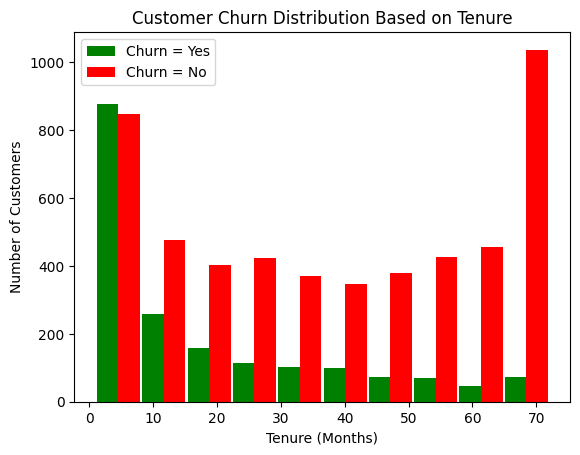

In [22]:
tenure_churn_no = df1[df1.Churn == 'No'].tenure  # Customers who did not churn
tenure_churn_yes = df1[df1.Churn == 'Yes'].tenure  # Customers who churned

plt.xlabel("Tenure (Months)")
plt.ylabel("Number of Customers")
plt.title("Customer Churn Distribution Based on Tenure")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['green', 'red'], label=['Churn = Yes', 'Churn = No'])
plt.legend()

**We can see that customer churn is highest in the early months and significantly decreases as tenure increases. Customers who stay longer are much less likely to leave, indicating strong loyalty among long-term subscribers.**

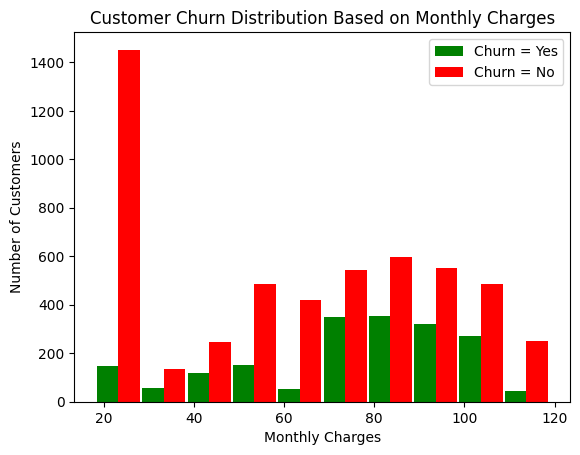

In [23]:
mc_churn_no = df1[df1.Churn == 'No'].MonthlyCharges  # Customers who did not churn
mc_churn_yes = df1[df1.Churn == 'Yes'].MonthlyCharges  # Customers who churned

plt.xlabel("Monthly Charges")
plt.ylabel("Number of Customers")
plt.title("Customer Churn Distribution Based on Monthly Charges")

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green', 'red'], label=['Churn = Yes', 'Churn = No'])
plt.legend()

**We can see that customers with low monthly charges tend to stay, while those with higher charges are more likely to churn**

**Several columns contain categorical data with "Yes" and "No" values. Let's display the unique values in all object-type columns to better understand the dataset.**

In [24]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

In [25]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some columns contain values like "No internet service" or "No phone service", which can be simplified by replacing them with "No" for consistency**

In [26]:
df1.replace('No internet service','No',inplace=True)
df1.replace('No phone service','No',inplace=True)

C:\Users\duyhu\AppData\Local\Temp\ipykernel_26296\2045096646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No internet service','No',inplace=True)
C:\Users\duyhu\AppData\Local\Temp\ipykernel_26296\2045096646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No phone service','No',inplace=True)


In [27]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Let's convert "Yes" and "No" values in the dataset to 1 and 0, respectively, for easier processing in machine learning models**

In [28]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

C:\Users\duyhu\AppData\Local\Temp\ipykernel_26296\1648037665.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[col].replace({'Yes': 1,'No': 0},inplace=True)
C:\Users\duyhu\AppData\Local\Temp\ipykernel_26296\1648037665.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1[col].replace({'Yes':

In [30]:
for col in df1:
    print(f'{col}: {df1[col].unique()}') 

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


**Convert "Female" and "Male" to 1 and 0, respectively, for numerical representation in the dataset**

In [31]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

C:\Users\duyhu\AppData\Local\Temp\ipykernel_26296\698335744.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['gender'].replace({'Female':1,'Male':0},inplace=True)
C:\Users\duyhu\AppData\Local\Temp\ipykernel_26296\698335744.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['gender'].repl

In [33]:
for col in df1:
    print(f'{col}: {df1[col].unique()}') 

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


**Apply one-hot encoding to categorical columns to convert them into numerical format, ensuring the dataset is suitable for machine learning models.**

In [34]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])

In [35]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5699,0,0,0,0,15,1,0,0,0,1,...,False,True,False,True,False,False,False,False,True,False
5774,0,0,0,0,5,1,0,0,1,0,...,True,False,False,True,False,False,True,False,False,False
5135,1,0,0,0,1,1,0,0,0,0,...,False,False,True,True,False,False,False,False,True,False
1408,1,0,1,0,71,1,1,1,0,1,...,False,True,False,False,True,False,False,True,False,False
3814,0,0,1,0,72,1,1,1,1,1,...,True,False,False,False,False,True,False,True,False,False


**Convert True and False values to 1 and 0 for numerical representation in the dataset**

In [36]:
bool_columns = df2.select_dtypes(include="bool").columns
df2[bool_columns] = df2[bool_columns].astype(int)

In [37]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5927,0,0,0,0,51,1,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
471,0,0,0,0,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1346,1,0,1,1,14,1,1,0,0,1,...,0,1,0,1,0,0,0,0,1,0
4042,0,0,0,0,5,1,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1769,0,0,1,0,71,1,1,0,1,1,...,0,1,0,1,0,0,1,0,0,0


**Normalize 'tenure', 'MonthlyCharges', and 'TotalCharges' using MinMaxScaler to scale values between 0 and 1**

In [38]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [39]:
for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

**With the data preprocessing completed, we are now ready to train our model**